In [17]:
import pandas as pd
import numpy as np
from IPython.display import HTML

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

#import nltk

# importing modules
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from langdetect import DetectorFactory, detect_langs


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ntn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ntn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ntn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
def combineCSVs():
  dft = pd.read_csv('https://raw.githubusercontent.com/oskarkris/cluster_project/main/csvdata/savedrecs%20(1).csv')
  print("read first")
  for n in range(2,13):
    print("read ", n)
    df_temp = pd.read_csv("https://raw.githubusercontent.com/oskarkris/cluster_project/main/csvdata/savedrecs%20("+str(n)+").csv")
    dft = pd.concat([dft, df_temp])
  return dft

def isEmpty(abstract):
    if abstract==" " or abstract=="":
        return True
    else:
        return False

def isEnglish(abstract):
    try:
        detected = detect_langs(abstract)
        lang = detected[0].lang
        prob = detected[0].prob
        if lang == "en" and prob > 0.95:
            return True
        else:
            return False
    except:
        return False

def make_clickable(url, name):
    return '<a href="{}" rel="noopener noreferrer" target="_blank">{}</a>'.format(url, name)

def remove_decimal(value):
    return str(value).replace('.0', '')

def generateDF():
    dft = combineCSVs()
    dft = dft.filter(["Publication Year", "Abstract", "UT (Unique WOS ID)", "Cited Reference Count", "Article Title"])
    dft = dft.rename(columns={"Publication Year" : "year", "UT (Unique WOS ID)": "wos", "Article Title": "title",  "Cited Reference Count": "citations", "Abstract": "abstract"})
    dft['year'] = dft['year'].apply(remove_decimal)
    dft["index"] = range(0, len(dft.index))
    dft["en"] = dft.apply(lambda x: isEnglish(x["abstract"]), axis=1)
    #Adds a link to Web of Science
    dft["link"] = dft.apply(lambda x: make_clickable("https://www.webofscience.com/wos/woscc/full-record/" + x["wos"], "link"), axis=1)
    dft = dft[['index', 'title', 'year', 'wos', 'en', 'link', 'abstract', 'citations']]
    return dft

def render(df):
    return HTML(df.to_html(render_links=True, escape=False))


In [19]:
stemmer = SnowballStemmer("porter")
lemmatizer = WordNetLemmatizer()

def remove_stopwords(abstract):
    stops = set(stopwords.words('english'))
    stops.update(['The', 'This','Climate','climate',
                  'Adaptation','adaptation','Change','change',
                  'Study', 'study', 'Germany', 'germany',
                   'Australia', 'australia', 'Canada', 'canada',
                   'Canadian', 'canadian', 'sic', 'We', 'we',
                     'Article', 'article', 'Paper', 'paper',
                     'review','Review','Research', 'research'
                  ])
    output= [i for i in abstract if not i in stops] 
    return output

def tokenize(abstract):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(abstract)

def lemma(abstract):
    lemmatized = []
    for w in abstract:
        if w.lower() == "copyright" or w.lower() == "c":
            break
        lemmatized.append(lemmatizer.lemmatize(w.lower()))
    return lemmatized

def stemming(abstract):
    # Change -> chang
    # Climate -> climat
    # We use Lemmatization instead
    stemmed = []
    for w in abstract:
        stemmed.append(stemmer.stem(w))
    return stemmed

def nlp(abstract):
    lst_text = lemma(remove_stopwords(tokenize(abstract)))
    return ' '.join(lst_text)

def clean_master(df):
    df = df[df.en != False]
    return df

def abstract_cleaner():
    df = pd.read_csv('master.csv')
    df = clean_master(df)
    df["clean_abstract"] = df.apply(
        lambda x: nlp(x["abstract"]), axis=1)
    df["abstract_length"] = df.apply(
        lambda x: len(x["clean_abstract"].split(" ")), axis=1)
    df.to_csv(
        r'master.csv', index=False)
    return df


In [20]:
from IPython.display import clear_output

def addAbstractsManually():
    try:
        indices = pd.read_csv(r"manualAbstracts.csv")

    except:
        df1 = pd.DataFrame(
            {
                "index": [],
                "abstract": []
            })
        df1.to_csv(r"manualAbstracts.csv")

    missingAbstracts = pd.read_csv(r'missingAbstracts.csv')
    missingAbstracts.set_index('index', drop=False, inplace=True)

    indices = pd.read_csv(r"manualAbstracts.csv")["index"].values.tolist()
    abstract = pd.read_csv(r"manualAbstracts.csv")['abstract'].values.tolist()

    for index, row in missingAbstracts.iterrows():
        if index in indices:
            print("item already has a manually inserted abstract")
        else:
            if str(row["abstract"]) == "nan":
                continue
            print("index: ", index, "\n", flush=True)
            print("Abstract: ", "\n", row["abstract"], flush=True)
            print("Link: ", "\n", row["link"], flush=True)
            a = input("Insert new abstract. Leave blank if you find no abstract. write ESC to quit")
            if a == "ESC":
                break
            if a =="":
                continue
            indices.append(index)
            abstract.append(a)
        clear_output(wait=True)

    data = {'index': indices,
                'abstract': abstract}
    pd.DataFrame(data).to_csv(r"manualAbstracts.csv", index=False)

In [23]:
def main(create_new, clean, addMan):
    if create_new:
        df = generateDF()
        df.loc[df['en'] == True].to_csv(r'master.csv', index=False)
        df.loc[df['en'] == False].to_csv(r'missingAbstracts.csv', index=False)

    if clean:
        abstract_cleaner()

    '''
    NB
    Du blir prompta til å oppgi abstrakt til en artikkel som mangler det når du kjører funksjonen
    Svaret ditt lagres i "manualAbstracts.csv"
    Om det ikke finnes et abstract sett det til "" - altså ikke legg til informasjon, bare press ENTER
    Når du er ferdig trykk ESCAPE
    '''

    if addMan:
        addAbstractsManually()
        df = pd.read_csv(r"master.csv")
        dm = pd.read_csv(r"manualAbstracts.csv")
        dc = pd.concat([df, dm])
        dc.to_csv(r"withManAddAbs.csv")

In [24]:
DetectorFactory.seed = 0 # seed for language detection

run = False

generate_new_csv = True
clean_csv = True
manuallyAddMissingAbstracts = False # Doesn't work properly

if run:
    main(generate_new_csv, clean_csv, manuallyAddMissingAbstracts)

item already has a manually inserted abstract


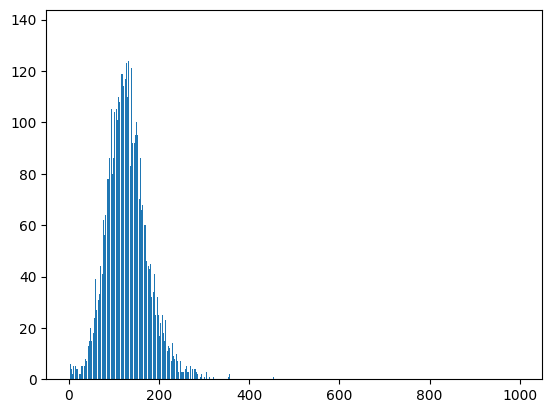

In [26]:
df = pd.read_csv(r"master.csv")
sizes = {}
vals = []
for i in range(0, 1000):
    sizes[i] = 0
for index, row in df.iterrows():
    a = row["abstract_length"]
    sizes[a] += 1
data = sizes
names = list(data.keys())
values = list(data.values())
plt.bar(range(len(data)), values)
plt.show()

In [27]:
df.head()

,index,title,year,wos,en,link,abstract,citations,clean_abstract,abstract_length
0,0,Financing Climate Change Adaptation: Internati...,2021.0,WOS:000666451800001,True,"<a href=""https://www.webofscience.com/wos/wosc...",Climate change adaptation is one of the main s...,27,one main strategy address global least develop...,64
1,1,Driving the agenda for climate change adaptati...,2013.0,WOS:000320956800008,True,"<a href=""https://www.webofscience.com/wos/wosc...",The absence of clear signals from the Norwegia...,55,absence clear signal norwegian state concernin...,62
2,2,Climate change adaptation policies and plans: ...,2018.0,WOS:000417078200110,True,"<a href=""https://www.webofscience.com/wos/wosc...",Building a climate-ready adaptation society is...,48,building ready society urgent question cannot ...,167
3,3,Place-based climate change adaptation: A criti...,2014.0,WOS:000345061100013,True,"<a href=""https://www.webofscience.com/wos/wosc...",Climate change adaptation frameworks often emp...,66,framework often emphasize tangible community v...,113
4,4,Responsibility for private sector adaptation t...,2014.0,WOS:000338711600014,True,"<a href=""https://www.webofscience.com/wos/wosc...",The Intergovernmental Panel on Climate Change ...,56,intergovernmental panel 2007 indicates vulnera...,168
